# Government of Canada (GC) employment by department

Public service employment source: https://www.canada.ca/en/treasury-board-secretariat/services/innovation/human-resources-statistics/population-federal-public-service-department.html

Canada population estimates source: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901

In [154]:
"""Load data from CSVs into DataFrames and normalize"""

import os

import pandas as pd
import numpy as np
import seaborn as sns

# Read CSVs from ./data directory to individual DataFrames
dfs = dict()
for filename in os.listdir('./data'):
    if filename.endswith('.csv'):
        dfs[filename[:-8]] = pd.read_csv('./data/' + filename)

# Load Canada population data
pop_df = pd.read_csv('./data/canada-population-esimates.csv')
pop_df = pop_df.T.reset_index()
# pop_df
pop_df.columns = ["Year", "Population"]
# Remove rows where Year doesn't start with "Q4"
pop_df = pop_df[pop_df['Year'].str.startswith('Q4')]
# Remove "Q4 " from Year column so it is just the year
pop_df['Year'] = pop_df['Year'].str.replace('Q4 ', '')
# Convert Year column to int
pop_df['Year'] = pop_df['Year'].astype(int)
# Convert Population column to int
pop_df['Population'] = pop_df['Population'].str.replace(",", "").astype(int)

# Normalize employees column to the year's population
# Year 2010 should be 1.0 because it is the base year
dfs['dept_pop_norm'] = dfs['dept'].copy()
dfs['dept_pop_norm'] = dfs['dept_pop_norm'].merge(pop_df, on='Year')
dfs['dept_pop_norm']['Employees'] = dfs['dept_pop_norm']['Employees'] / dfs['dept_pop_norm']['Population']
dfs['dept_pop_norm']['Employees'] *= pop_df.query('Year == 2010')['Population'].values[0]
dfs['dept_pop_norm'] = dfs['dept_pop_norm'].drop(columns=['Population'])
# dfs['dept_pop_norm'].head()

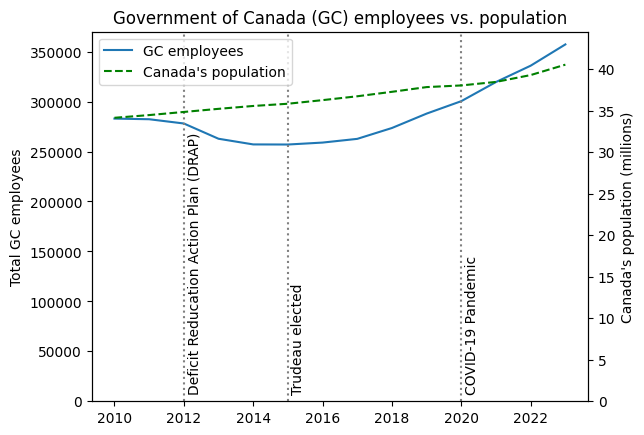

In [155]:
"""GC employees vs. population"""

from matplotlib import pyplot as plt
employees = dfs['dept'].drop(columns=['Universe']).groupby(['Year']).sum()
ln1 = plt.plot(employees.index, employees['Employees'])
plt.title('Government of Canada (GC) employees vs. population')
# Draw a vertical line at 2015 for Trudeau's election
plt.axvline(x=2015, color='gray', linestyle='dotted')
# Label the vertical line
plt.text(2015.1, 10000, 'Trudeau elected', rotation=90)
# Same for pandemic in 2020
plt.axvline(x=2020, color='gray', linestyle='dotted')
plt.text(2020.1, 10000, 'COVID-19 Pandemic', rotation=90)
# Same for DRAP in 2012
plt.axvline(x=2012, color='gray', linestyle='dotted')
plt.text(2012.1, 10000, 'Deficit Reducation Action Plan (DRAP)', rotation=90)
# Set y-label to "Total employees"
plt.ylabel('Total GC employees')
# Set y-limits to 0, 370k
plt.ylim(0, 370000)

# Add a horizontal line for the 2010 value
# plt.axhline(y=employees.loc[2010]['Employees'], color='gray', linestyle='dotted')
# Label the horizontal line
# plt.text(2023, employees.loc[2010]['Employees'] - 13000, '2010 value', horizontalalignment='right')

# Add the population of Canada to the plot with a separate axis on the right
ax2 = plt.twinx()

# Plot the population of Canada
ln2 = ax2.plot(pop_df['Year'], pop_df['Population'] / 1000000, color='green', linestyle='--')
# Set the y-axis limits
ax2.set_ylim(0, 44.5)
# Set the y-axis label
ax2.set_ylabel('Canada\'s population (millions)')

# Add a single legend for both ln1 and ln2
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
plt.legend(lns, ["GC employees", "Canada's population"], loc="upper left")
plt.show()

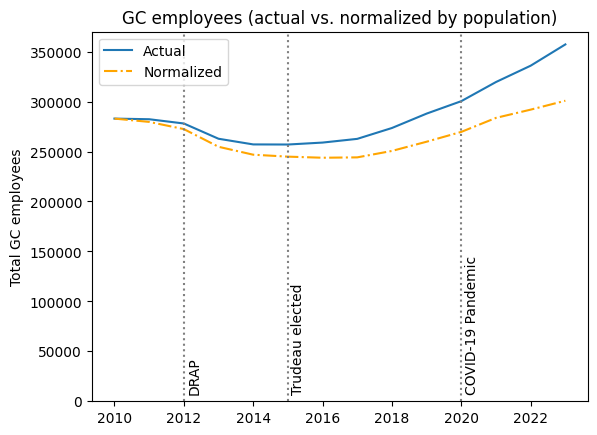

In [156]:
"""Effect of normalizing GC employees vs. population"""

normalized = dfs['dept_pop_norm'].drop(columns=['Universe']).groupby(['Year']).sum()
without_norm = dfs['dept'].drop(columns=['Universe']).groupby(['Year']).sum()
# Plot both lines on the same graph
# without_norm.plot(ylim=(0, 370000)).title.set_text('GC employees (actual vs. normalized by population)')
plt.plot(without_norm["Employees"])
plt.plot(normalized["Employees"], color='orange', linestyle='-.')

# Set y limits to 0, 370000
plt.ylim(0, 370000)
# Set title to "GC employees (actual vs. normalized by population)"
plt.title('GC employees (actual vs. normalized by population)')
# Add legend
plt.legend(["Actual", "Normalized"], loc='upper left')

# Draw a vertical line at 2015 for Trudeau's election
plt.axvline(x=2015, color='gray', linestyle='dotted')
# Label the vertical line
plt.text(2015.1, 10000, 'Trudeau elected', rotation=90)
# Same for pandemic in 2020
plt.axvline(x=2020, color='gray', linestyle='dotted')
plt.text(2020.1, 10000, 'COVID-19 Pandemic', rotation=90)
# Same for DRAP in 2012
plt.axvline(x=2012, color='gray', linestyle='dotted')
plt.text(2012.1, 10000, 'DRAP', rotation=90)

# Add a horizontal line for the 2010 value
# plt.axhline(y=employees.loc[2010]['Employees'], color='gray', linestyle='dotted')
# Label the horizontal line
# plt.text(2023, employees.loc[2010]['Employees'] - 13000, '2010 value', horizontalalignment='right')

# Set y-label to "Total employees"
plt.ylabel('Total GC employees')
plt.show()

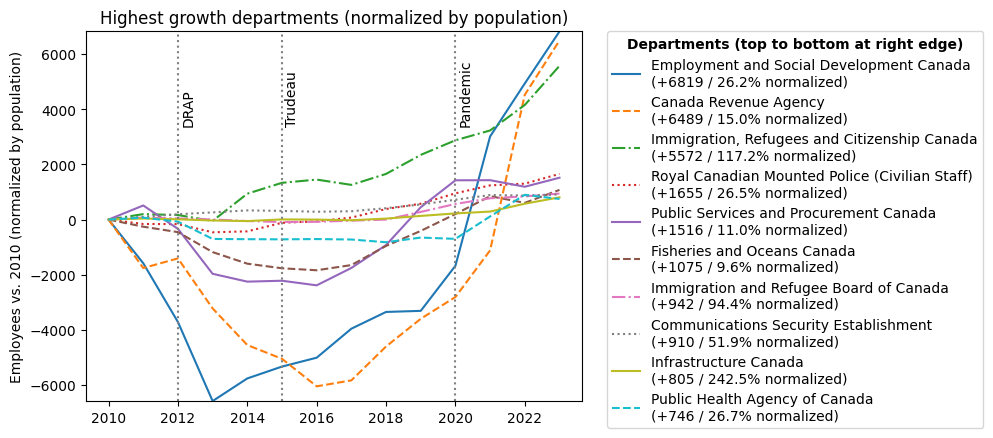

In [157]:
"""Top 10 departments by growth in absolute numbers, normalized by population"""

df = dfs["dept_pop_norm"]
df = df.drop(columns=['Universe'])

df_scaled = df.copy()
emp_2010 = df[df['Year'] == 2010]
emp_2010 = emp_2010.drop(columns=['Year']).set_index('Departments and Agencies')
df_scaled = df_scaled.merge(emp_2010, on='Departments and Agencies', how='left', suffixes=('', '_2010'))
df_scaled["Employees"] = df_scaled["Employees"] - df_scaled["Employees_2010"]

df_scaled = df_scaled.drop(columns=['Employees_2010'])

max_y = df_scaled["Employees"].max()
min_y = df_scaled["Employees"].min()

top_depts = df_scaled.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(10).index.tolist()

line_styles = ['-', '--', '-.', ':']
line_style_index = 0
for dept in top_depts:
    dept_size_by_year = df_scaled[df_scaled['Departments and Agencies'] == dept]
    plt.plot(dept_size_by_year['Year'], dept_size_by_year['Employees'], label=dept, linestyle=line_styles[line_style_index%len(line_styles)])
    line_style_index += 1


# Draw a vertical line at 2015 for Trudeau's election
plt.axvline(x=2015, color='gray', linestyle='dotted')
# Label the vertical line
plt.text(2015.1, 3500, 'Trudeau', rotation=90)
# Same for pandemic in 2020
plt.axvline(x=2020, color='gray', linestyle='dotted')
plt.text(2020.1, 3500, 'Pandemic', rotation=90)
# Same for DRAP in 2012
plt.axvline(x=2012, color='gray', linestyle='dotted')
plt.text(2012.1, 3500, 'DRAP', rotation=90)

# Calculate growth totals and percentage growth for each department, then add these to the legend
growth_percentages = 100 * df_scaled.set_index("Departments and Agencies").query("Year == 2023")["Employees"] / emp_2010["Employees"]

growth_totals = (
    df_scaled.set_index("Departments and Agencies").query("Year == 2023")["Employees"]
)

# Add growth totals and percentages to legend
legend_labels = []
for dept in top_depts:
    legend_labels.append(
        f"{dept}\n(+{growth_totals[dept]:.0f} / {growth_percentages[dept]:.1f}% normalized)"
    )

plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Departments (top to bottom at right edge)')
# Legend title should be bold and left-aligned
plt.setp(plt.gca().get_legend().get_title(), fontweight='bold')
plt.ylim(min_y, max_y)
plt.ylabel('Employees vs. 2010 (normalized by population)')
plt.title('Highest growth departments (normalized by population)')
plt.show()

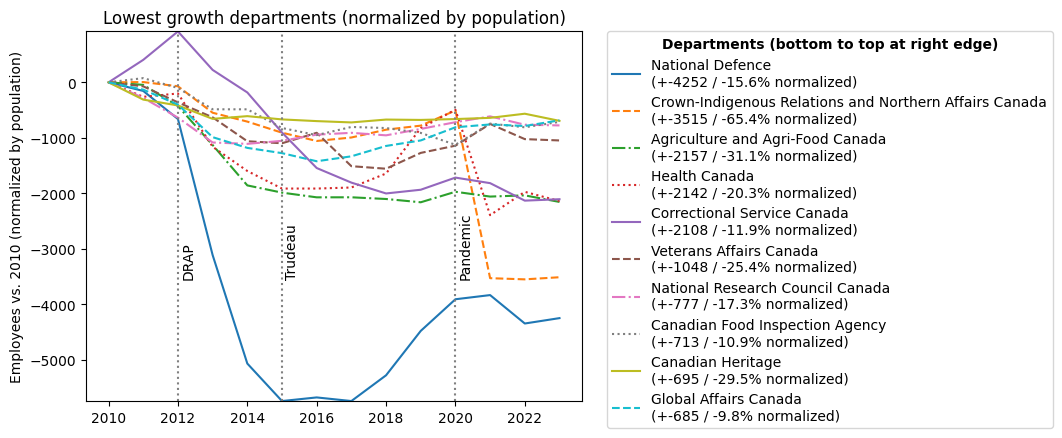

In [158]:
"""Bottom 10 departments by growth in absolute numbers (i.e. shrinking), normalized by population"""

df = dfs["dept_pop_norm"]
df = df.drop(columns=['Universe'])

df_scaled = df.copy()
emp_2010 = df[df['Year'] == 2010]
emp_2010 = emp_2010.drop(columns=['Year']).set_index('Departments and Agencies')
df_scaled = df_scaled.merge(emp_2010, on='Departments and Agencies', how='left', suffixes=('', '_2010'))
df_scaled["Employees"] = df_scaled["Employees"] - df_scaled["Employees_2010"]

df_scaled = df_scaled.drop(columns=['Employees_2010'])

top_depts = df_scaled.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=True).head(10).index.tolist()

df_scaled = df_scaled[df_scaled['Departments and Agencies'].isin(top_depts)]

max_y = df_scaled["Employees"].max()
min_y = df_scaled["Employees"].min()

line_styles = ['-', '--', '-.', ':']
line_style_index = 0
for dept in top_depts:
    dept_size_by_year = df_scaled[df_scaled['Departments and Agencies'] == dept]
    plt.plot(dept_size_by_year['Year'], dept_size_by_year['Employees'], label=dept, linestyle=line_styles[line_style_index%len(line_styles)])
    line_style_index += 1

# Draw a vertical line at 2015 for Trudeau's election
plt.axvline(x=2015, color='gray', linestyle='dotted')
# Label the vertical line
plt.text(2015.1, -3500, 'Trudeau', rotation=90)
# Same for pandemic in 2020
plt.axvline(x=2020, color='gray', linestyle='dotted')
plt.text(2020.1, -3500, 'Pandemic', rotation=90)
# Same for DRAP in 2012
plt.axvline(x=2012, color='gray', linestyle='dotted')
plt.text(2012.1, -3500, 'DRAP', rotation=90)


# Calculate growth totals and percentage growth for each department, then add these to the legend
growth_percentages = 100 * df_scaled.set_index("Departments and Agencies").query("Year == 2023")["Employees"] / emp_2010["Employees"]

growth_totals = (
    df_scaled.set_index("Departments and Agencies").query("Year == 2023")["Employees"]
)

# Add growth totals and percentages to legend
legend_labels = []
for dept in top_depts:
    legend_labels.append(
        f"{dept}\n(+{growth_totals[dept]:.0f} / {growth_percentages[dept]:.1f}% normalized)"
    )

plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Departments (bottom to top at right edge)')

# Legend title should be bold and left-aligned
plt.setp(plt.gca().get_legend().get_title(), fontweight='bold')
plt.ylim(min_y, max_y)
plt.ylabel('Employees vs. 2010 (normalized by population)')
plt.title('Lowest growth departments (normalized by population)')
plt.show()

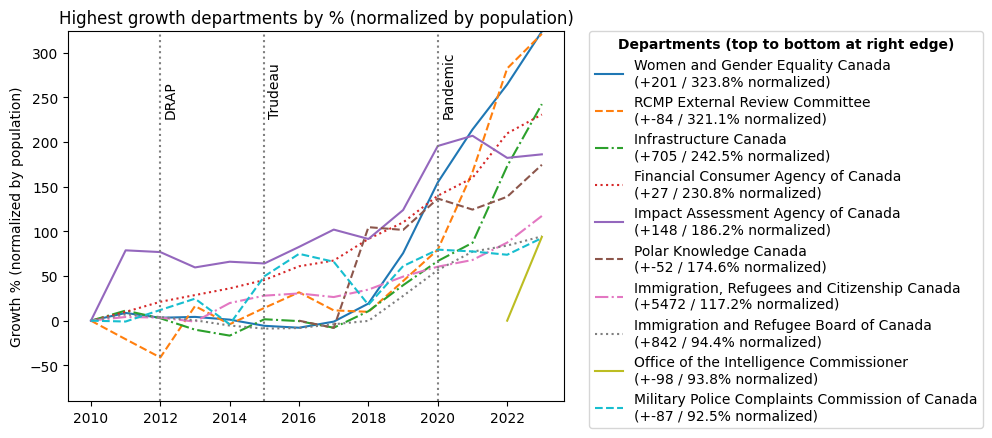

In [160]:
"""Top 10 departments (any size dept) by growth in proportional numbers, normalized by population"""

df = dfs["dept_pop_norm"]
df.replace(0, np.nan, inplace=True)
df = df.drop(columns=['Universe'])

# For each department, find the first year that it had more than 0 employees - and keep only that row.
# This is the first year that the department existed in the data.

df_first_year = df.dropna().sort_values(['Year']).groupby(['Departments and Agencies']).first().reset_index()
df_first_year

# For each department, normalize the number of employees to 100% in the first year that it had more than 0 employees.
# This is the ratio of employees in each year to the number of employees in the first year that the department existed.

df_growth = df.merge(df_first_year, on='Departments and Agencies', how='left', suffixes=('', '_first'))
df_growth["Employees"] = 100 * df_growth["Employees"] / df_growth["Employees_first"] - 100
df_growth = df_growth.drop(columns=['Employees_first', 'Year_first'])

# Plot the top 10 departments by growth in proportional numbers
max_y = df_growth["Employees"].max()
min_y = df_growth["Employees"].min()

top_depts = df_growth.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(10).index.tolist()

df_growth = df_growth[df_growth['Departments and Agencies'].isin(top_depts)]

line_styles = ['-', '--', '-.', ':']
line_style_index = 0
for dept in top_depts:
    dept_size_by_year = df_growth[df_growth['Departments and Agencies'] == dept]
    plt.plot(dept_size_by_year['Year'], dept_size_by_year['Employees'], label=dept, linestyle=line_styles[line_style_index%len(line_styles)])
    line_style_index += 1


# Draw a vertical line at 2015 for Trudeau's election
plt.axvline(x=2015, color='gray', linestyle='dotted')
# Label the vertical line
plt.text(2015.1, 230, 'Trudeau', rotation=90)
# Same for pandemic in 2020
plt.axvline(x=2020, color='gray', linestyle='dotted')
plt.text(2020.1, 230, 'Pandemic', rotation=90)
# Same for DRAP in 2012
plt.axvline(x=2012, color='gray', linestyle='dotted')
plt.text(2012.1, 230, 'DRAP', rotation=90)

# Calculate growth totals and percentage growth for each department, then add these to the legend
df_growth_tot = df.merge(df_first_year, on='Departments and Agencies', how='left', suffixes=('', '_first'))
df_growth_tot["Employees"] = df_growth_tot["Employees"] - df_growth_tot["Employees_first"] - 100
df_growth_tot = df_growth_tot.drop(columns=['Employees_first', 'Year_first'])
growth_totals = df_growth_tot.set_index("Departments and Agencies").query("Year == 2023")["Employees"]
growth_percentages = df_growth.set_index("Departments and Agencies").query("Year == 2023")["Employees"]

# Add growth totals and percentages to legend
legend_labels = []
for dept in top_depts:
    legend_labels.append(
        f"{dept}\n(+{growth_totals[dept]:.0f} / {growth_percentages[dept]:.1f}% normalized)"
    )

plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Departments (top to bottom at right edge)')
# Legend title should be bold
plt.setp(plt.gca().get_legend().get_title(), fontweight='bold')

plt.ylim(min_y, max_y)
plt.ylabel('Growth % (normalized by population)')
plt.title('Highest growth departments by % (normalized by population)')
plt.show()

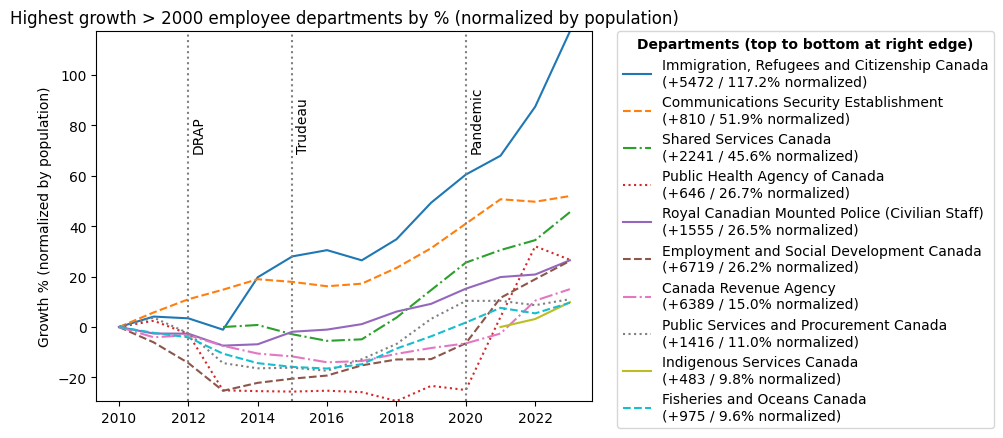

In [161]:
"""Top 10 departments (only > 2000 employees) by growth in proportional numbers, normalized by population"""

df = dfs["dept_pop_norm"]
df.replace(0, np.nan, inplace=True)
df = df.drop(columns=['Universe'])

# For each department, find the first year that it had more than 0 employees - and keep only that row.
# This is the first year that the department existed in the data.

df_first_year = df.dropna().sort_values(['Year']).groupby(['Departments and Agencies']).first().reset_index()
df_first_year

# For each department, normalize the number of employees to 100% in the first year that it had more than 0 employees.
# This is the ratio of employees in each year to the number of employees in the first year that the department existed.

df_growth = df.merge(df_first_year, on='Departments and Agencies', how='left', suffixes=('', '_first'))

# Filter to only departments which had more than 2000 employees in any year
large_depts = df_growth.groupby(['Departments and Agencies']).max().sort_values(by=['Employees'], ascending=False).query("Employees > 2000").index.tolist()
df_growth = df_growth[df_growth['Departments and Agencies'].isin(large_depts)]

df_growth["Employees"] = 100 * df_growth["Employees"] / df_growth["Employees_first"] - 100
df_growth = df_growth.drop(columns=['Employees_first', 'Year_first'])

top_depts = df_growth.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(10).index.tolist()

df_growth = df_growth[df_growth['Departments and Agencies'].isin(top_depts)]
# Plot the top 10 departments by growth in proportional numbers
max_y = df_growth["Employees"].max()
min_y = df_growth["Employees"].min()

line_styles = ['-', '--', '-.', ':']
line_style_index = 0
for dept in top_depts:
    dept_size_by_year = df_growth[df_growth['Departments and Agencies'] == dept]
    plt.plot(dept_size_by_year['Year'], dept_size_by_year['Employees'], label=dept, linestyle=line_styles[line_style_index%len(line_styles)])
    line_style_index += 1


# Draw a vertical line at 2015 for Trudeau's election
plt.axvline(x=2015, color='gray', linestyle='dotted')
# Label the vertical line
plt.text(2015.1, 70, 'Trudeau', rotation=90)
# Same for pandemic in 2020
plt.axvline(x=2020, color='gray', linestyle='dotted')
plt.text(2020.1, 70, 'Pandemic', rotation=90)
# Same for DRAP in 2012
plt.axvline(x=2012, color='gray', linestyle='dotted')
plt.text(2012.1, 70, 'DRAP', rotation=90)

# Calculate growth totals and percentage growth for each department, then add these to the legend
df_growth_tot = df.merge(df_first_year, on='Departments and Agencies', how='left', suffixes=('', '_first'))
df_growth_tot["Employees"] = df_growth_tot["Employees"] - df_growth_tot["Employees_first"] - 100
df_growth_tot = df_growth_tot.drop(columns=['Employees_first', 'Year_first'])
growth_totals = df_growth_tot.set_index("Departments and Agencies").query("Year == 2023")["Employees"]
growth_percentages = df_growth.set_index("Departments and Agencies").query("Year == 2023")["Employees"]

# Add growth totals and percentages to legend
legend_labels = []
for dept in top_depts:
    legend_labels.append(
        f"{dept}\n(+{growth_totals[dept]:.0f} / {growth_percentages[dept]:.1f}% normalized)"
    )

plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Departments (top to bottom at right edge)')
# Legend title should be bold
plt.setp(plt.gca().get_legend().get_title(), fontweight='bold')

plt.ylim(min_y, max_y)
plt.ylabel('Growth % (normalized by population)')
plt.title('Highest growth > 2000 employee departments by % (normalized by population)')
plt.show()

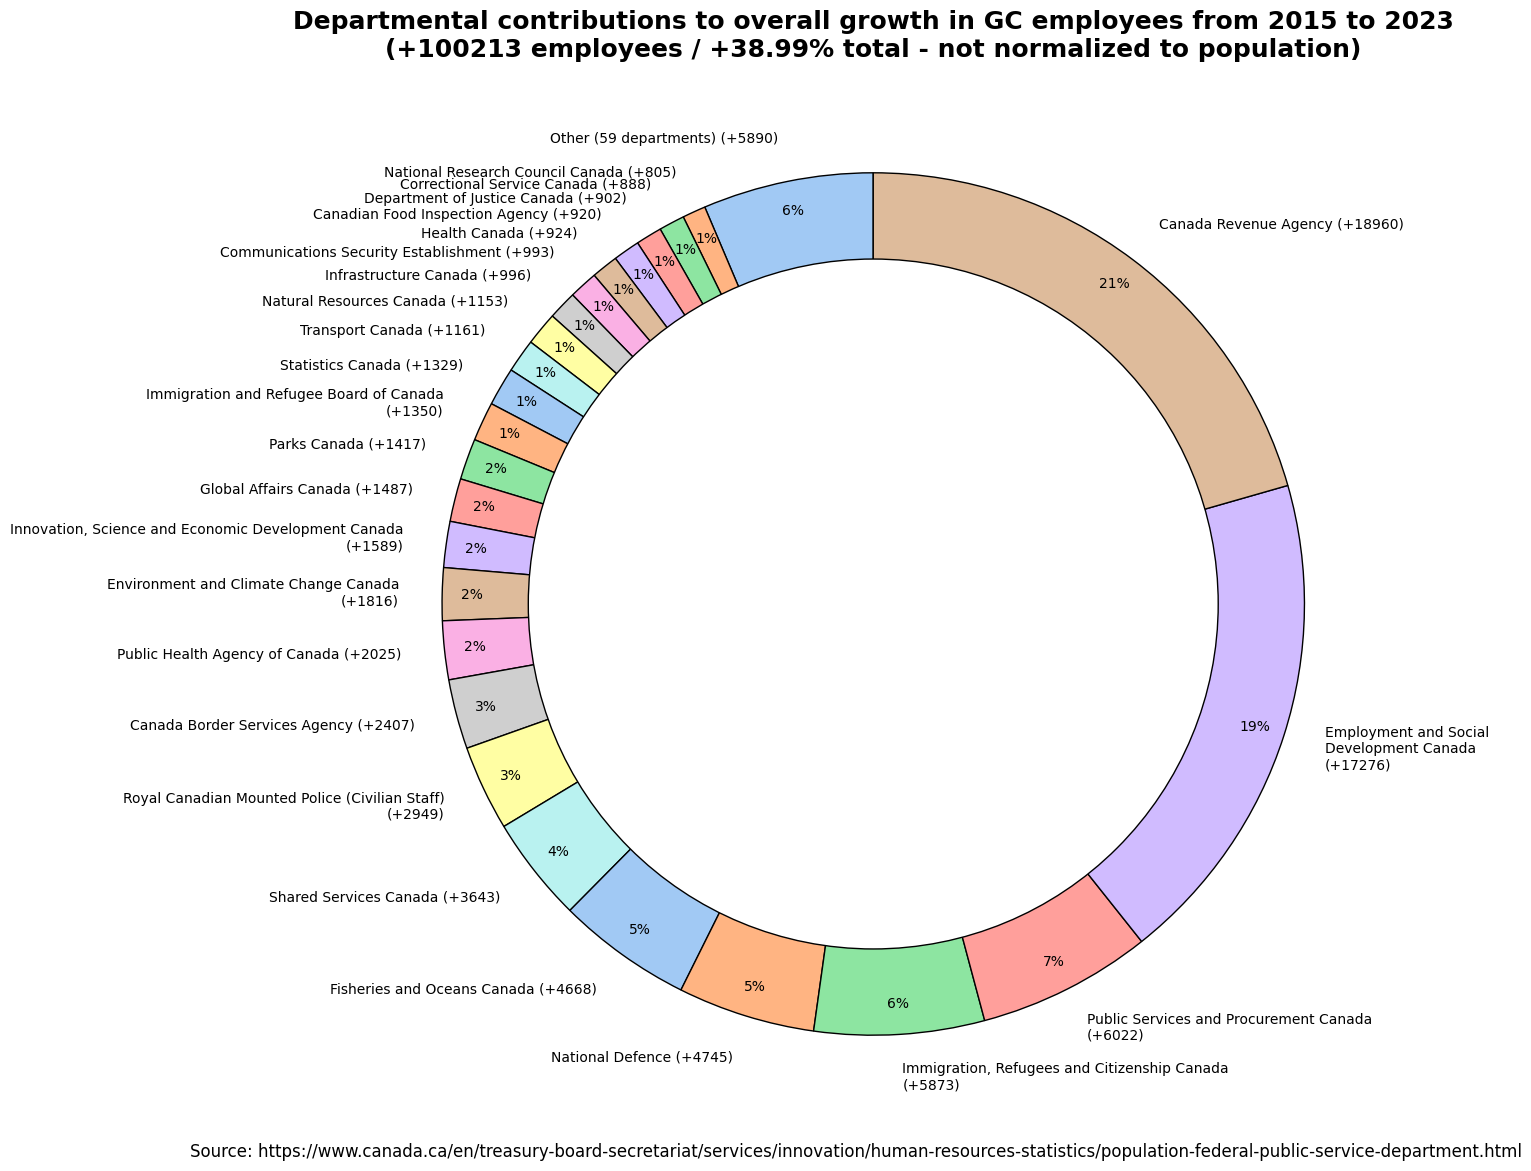

In [162]:
"""Departmental contribution to overall growth in GC employees under Trudeau"""

df = dfs["dept"]
df = df.drop(columns=["Universe"])

# What is the absolute difference between 2023 values and 2015 values, for each department?
df_2023 = df[df["Year"] == 2023]
df_2015 = df[df["Year"] == 2015]
df_2015 = df_2015.drop(columns=["Year"])
df_2015 = df_2015.set_index("Departments and Agencies")
df_2023 = df_2023.drop(columns=["Year"])
df_2023 = df_2023.set_index("Departments and Agencies")

# Find the difference between 2023 and 2015
total_diff = df_2023["Employees"].sum() - df_2015["Employees"].sum()
percent_diff = 100 * df_2023["Employees"].sum() / df_2015["Employees"].sum() - 100

df_diff = df_2023 - df_2015
df_diff = df_diff.reset_index()
df_diff = df_diff.sort_values(by=["Employees"], ascending=False)
# Pie chart of all departments by Diff
df_diff = df_diff.sort_values(by=["Employees"], ascending=True)
# Group the smallest growth departments together
# How many small departments?
min_size = 800
num_small = df_diff[df_diff["Employees"] < min_size].shape[0]
other_name = f"Other ({num_small} departments)"
df_diff.loc[df_diff["Employees"] < min_size, "Departments and Agencies"] = other_name
df_diff = df_diff.groupby(["Departments and Agencies"]).sum().reset_index()
df_diff = df_diff.sort_values(by=["Employees"], ascending=True)
# Put the "other" category last
df_diff2 = df_diff[df_diff["Departments and Agencies"] != other_name]
df_diff2 = pd.concat(
    [
        df_diff[df_diff["Departments and Agencies"] == other_name],
        df_diff2,
    ]
)
# Drop rows with 0 employees
df_diff2 = df_diff2[df_diff2["Employees"] != 0]
# Find the % increase for each of the departments in df_diff2
# First, combine the departments NOT in df_diff2 into the other_name category
df_2015 = df_2015.reset_index()
df_2015.loc[~(df_2015["Departments and Agencies"].isin(df_diff2["Departments and Agencies"])), "Departments and Agencies"] = other_name
df_2015 = df_2015.groupby(["Departments and Agencies"]).sum().reset_index()
df_diff2 = df_diff2.merge(
    df_2015, on="Departments and Agencies", how="left", suffixes=("", "_2015")
)
df_diff2["% increase"] = (
    100 * df_diff2["Employees"] / df_diff2["Employees_2015"]
)
# Replace zero with infinity symbol
df_diff2["% increase"] = df_diff2["% increase"].replace(np.inf, "∞")
# Round to 1 decimal place
df_diff2["% increase"] = df_diff2["% increase"].round(1)

df_diff2["Departments and Agencies"] = df_diff2["Departments and Agencies"].replace(
    "Employment and Social Development Canada",
    "Employment and Social\nDevelopment Canada",
)
# Add the absolute number and % to the end of the "Departments and Agencies" column in parens
df_diff2["Departments and Agencies"] = (
    df_diff2["Departments and Agencies"]
    + " (+"
    + df_diff2["Employees"].astype(int).astype(str)
    + ")"
    # + ", +"
    # + df_diff2["% increase"].astype(str)
    # + "%)"
)
# If the line is too long (X chars), add a line break before the parentheses
# Or if its one the following:
line_break_depts = [
    "Innovation, Science and Economic Development Canada",
    "Environment and Climate Change Canada",
]
df_diff2["Departments and Agencies"] = df_diff2["Departments and Agencies"].apply(
    lambda x: x.replace(" (+", "\n(+") if len(x) > 45 or x.split("(")[0].strip() in line_break_depts else x
)

df_diff2.plot.pie(
    y="Employees",
    labels=df_diff2["Departments and Agencies"],
    figsize=(14, 14),
    autopct="%1.0f%%",
    startangle=90,
    legend=False,
    # Light pastel colors for text contrast
    colors=sns.color_palette("pastel"),
    # The slices should have a black outline
    wedgeprops={"linewidth": 1, "edgecolor": "black"},
    # Only show the percent labels if the slice is large enough
    pctdistance=0.93,
)
# Don't show the y-axis label
plt.ylabel("")
# Left-align the title
plt.title(
    (
        "Departmental contributions to overall growth in GC employees from 2015 to 2023\n"
        f"(+{total_diff} employees / +{percent_diff:.2f}% total - not normalized to population)"
    ),
    fontsize=18,
    fontdict=(
        # Bold the title
        {"fontweight": "bold"}
    ),
)
# Take out the middle of the pie chart to make it a donut
centre_circle = plt.Circle((0, 0), 0.8, fc="white")
# The circle needs a border like the slices, black and 1px wide
centre_circle.set_edgecolor("black")
centre_circle.set_linewidth(1)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Add source text to the bottom
plt.figtext(
    0.5,
    0.1,
    "Source: https://www.canada.ca/en/treasury-board-secretariat/services/innovation/human-resources-statistics/population-federal-public-service-department.html",
    ha="center",
    fontsize=12,
)
plt.show()
# Finally, add an inset graph in the centre of the donut
# a = plt.axes([.4, .4, .25, .25], facecolor='y')


In [212]:
"""Departmental breakdown of GC employees over time, not normalized"""

# stacked area chart of the top departments by employees per year
# group all but the top departments into "other"
# then plot the top depts + other with plotly

df = dfs["dept"]
df = df.drop(columns=["Universe"])

# top 10 departments by employees overall
top_depts = df.groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(30).index.tolist()

all_depts = df["Departments and Agencies"].unique().tolist()
num_other_depts = len(all_depts) - len(top_depts)
# group all but the top 10 departments into "other"
other_str = f"Other ({num_other_depts} smallest departments)"
df["Departments and Agencies"] = df["Departments and Agencies"].apply(lambda x: x if x in top_depts else other_str)

# group by year and department
df = df.groupby(['Year', 'Departments and Agencies']).sum().reset_index()

# Update the department column names to include the number of employees in 2023
# This will be used as the legend
df_2023 = df[df["Year"] == 2023]
df_2023 = df_2023.drop(columns=["Year"])
df_2023 = df_2023.set_index("Departments and Agencies")
df = df.merge(df_2023, on="Departments and Agencies", how="left", suffixes=("", "_2023"))
df.sort_values(by=["Employees_2023"], ascending=False, inplace=True)
df["Departments and Agencies"] = (
    df["Departments and Agencies"]
    + " ("
    + df["Employees_2023"].astype(int).astype(str)
    + ")"
)
dept_names = df["Departments and Agencies"].tolist()

# pivot to wide format
df = df.pivot(index='Year', columns='Departments and Agencies', values='Employees').reset_index()

# plot with plotly
import plotly.express as px

fig = px.area(df, x="Year", y=dept_names, title='GC employees by department, 2010 to 2023 (not normalized)')

# Add vertical lines for Trudeau, DRAP and Pandemic
for year, label in zip([2015, 2012, 2020], ['Trudeau', 'DRAP', 'Pandemic']):
    fig.add_vline(x=year, line_width=1, line_dash="dot", line_color="black")
    # Rotate label 90 degrees
    fig.add_annotation(
        x=year,
        y=335000,
        text=label,
        showarrow=False,
        textangle=-90,
        xanchor="left",
        xshift=5,
        font=dict(
            size=12,
            color="black"
        )
    )

# Add source text to the bottom
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=0,
    y=-0.12,
    text="Source: https://www.canada.ca/en/treasury-board-secretariat/services/innovation/human-resources-statistics/population-federal-public-service-department.html",
    showarrow=False,
)

# Change legend title
fig.update_layout(legend_title_text='Department (employees in 2023); bottom to top on graph')
# y-axis label
fig.update_yaxes(title_text='GC employees by department (not normalized by population)')

# Change height to make it more square
fig.update_layout(height=800)
fig.show()

In [213]:
"""Change in GC employees over time by department, normalized to population"""

df = dfs["dept_pop_norm"]
df = df.drop(columns=['Universe'])

df_scaled = df.copy()
emp_2010 = df[df['Year'] == 2010]
emp_2010 = emp_2010.drop(columns=['Year']).set_index('Departments and Agencies')
df_scaled = df_scaled.merge(emp_2010, on='Departments and Agencies', how='left', suffixes=('', '_2010'))
df_scaled["Employees"] = df_scaled["Employees"] - df_scaled["Employees_2010"]

df_scaled = df_scaled.drop(columns=['Employees_2010'])

max_y = df_scaled["Employees"].max()
min_y = df_scaled["Employees"].min()

top_depts = df_scaled.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(10).index.tolist()

df = df_scaled
# group all but the top 10 departments into "other"
df["Departments and Agencies"] = df["Departments and Agencies"].apply(lambda x: x if x in top_depts else "Other")

# group by year and department
df = df.groupby(['Year', 'Departments and Agencies']).sum().reset_index()

# pivot to wide format
df = df.pivot(index='Year', columns='Departments and Agencies', values='Employees').reset_index()

# plot with plotly
import plotly.express as px

fig = px.area(df, x="Year", y=["Other"] + top_depts, title='Change in GC employees by department, 2010 to 2023 (normalized by population)')

# Add vertical lines for Trudeau, DRAP and Pandemic
for year, label in zip([2015, 2012, 2020], ['Trudeau', 'DRAP', 'Pandemic']):
    fig.add_vline(x=year, line_width=1, line_dash="dot", line_color="black")
    # Rotate label 90 degrees
    fig.add_annotation(
        x=year,
        y=-6000,
        text=label,
        showarrow=False,
        textangle=-90,
        xanchor="left",
        xshift=5,
        font=dict(
            size=12,
            color="black"
        )
    )

fig.show()